## Rainfall prediction analysis
## Including improved dry day classification model

In [1]:
import import_ipynb
import pandas as pd
import numpy as np

import sys
sys.path.append("../")
from asset.DataSupply import GetData, GetSewageAndRainfall

In [2]:
df_sewage_pump_connection, df_rain_historical = GetSewageAndRainfall()
df_predicted = pd.read_csv(
    r"../asset/data/rain_prediction.csv",sep=';'
)
df_predicted["Eind"] = df_predicted["Eind"].apply(
    pd.to_datetime, format="%Y-%m-%d %H:%M:%S"
)
df_predicted = df_predicted.set_index("Eind")

act_times = set(df_rain_historical.index)
pred_times = set(df_predicted.index)
intersect_times = set(act_times & pred_times)

100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:05<00:00,  4.22it/s]


<IPython.core.display.Javascript object>

In [3]:
df_rain_historical.columns[df_rain_historical.columns.isin(df_predicted.columns)]

Index(['Sportpark de Vliert(Sportiom)', 'Kastanjelaan', 'Woonwagencentrum',
       'geb. 6c Carolushof', 'Geb. 6a Redemptoristenpad A',
       'Geb.20 Schutskamp / Nieuw Deuteren', 'Geb. 8 Orthenpoort',
       'Hedikhuizen', 'Geb. 19 Deuteren', 'Heusden-vesting', 'Bokhoven',
       'Poeldonkweg', 'Meeuwaert', 'Geb. 12 Vughterpoort'],
      dtype='object')

<IPython.core.display.Javascript object>

In [4]:
def MarkDryWeather(df, location):
    df[f"dry_{location}"] = 0
    for i in range(24, len(df[location])):
        if df[location][i - 24 : i + 1].sum() == 0:
            df[f"dry_{location}"][i] = 1


rain = pd.read_csv(
    r"../asset/data/rain.csv"
)
rain.drop(["grid_maaspoort", "grid_rompert"], axis=1)
locs = [
    "act_haarsteeg",
    "act_bokhoven",
    "act_helft_heuvelweg",
    "act_maaspoort_rompert",
    "act_oud_engelseweg",
]
for x in locs:
    MarkDryWeather(rain, x)

rain = rain.fillna(0)
rain.head()
difference = rain.copy()
difference["haarsteeg"] = difference["act_haarsteeg"] - difference["grid_haarsteeg"]
difference["bokhoven"] = difference["act_bokhoven"] - difference["grid_bokhoven"]
difference["helft_heuvelweg"] = (
    difference["act_helft_heuvelweg"] - difference["grid_helft_heuvelweg"]
)
difference["maaspoort_rompert"] = (
    difference["act_maaspoort_rompert"] - difference["grid_maaspoort_rompert"]
)
difference["oud_engelseweg"] = (
    difference["act_oud_engelseweg"] - difference["grid_oud_engelseweg"]
)
difference = difference[
    [
        "Begin",
        "haarsteeg",
        "bokhoven",
        "helft_heuvelweg",
        "maaspoort_rompert",
        "oud_engelseweg",
    ]
]
difference2 = difference.drop(["Begin"], axis=1)
print(sum(n > 0 for n in difference2.values))
print(sum(n < 0 for n in difference2.values))
print(sum(n == 0 for n in difference2.values))

len(difference2.values)
# sum(n > 0 for n in difference2)
# for index, row in difference.iterrows():

<ipython-input-4-2726443104b3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"dry_{location}"][i] = 1


[1361 1122 1483 1354 1316]
[6331 4744 5642 5674 5627]
[6131 7957 6698 6795 6880]


13823

<IPython.core.display.Javascript object>

In [5]:

haar, bok, helf, maas, oud = [], [], [], [], []
haar = pd.DataFrame(
    data={
        "Begin": rain["Begin"],
        "grid_haarsteeg": rain["grid_haarsteeg"],
        "act_haarsteeg": rain["act_haarsteeg"],
        "difference": difference["haarsteeg"],
        "dry_act_haarsteeg": rain["dry_act_haarsteeg"]
    }
)
bok = pd.DataFrame(
    data={
        "Begin": rain["Begin"],
        "grid_haarsteeg": rain["grid_bokhoven"],
        "act_haarsteeg": rain["act_bokhoven"],
        "difference": difference["bokhoven"],
        "dry_act_haarsteeg": rain["dry_act_bokhoven"]
    }
)
helf = pd.DataFrame(
    data={
        "Begin": rain["Begin"],
        "grid_haarsteeg": rain["grid_helft_heuvelweg"],
        "act_haarsteeg": rain["act_helft_heuvelweg"],
        "difference": difference["helft_heuvelweg"],
        "dry_act_haarsteeg": rain["dry_act_helft_heuvelweg"]
    }
)
maas = pd.DataFrame(
    data={
        "Begin": rain["Begin"],
        "grid_haarsteeg": rain["grid_maaspoort_rompert"],
        "act_haarsteeg": rain["act_maaspoort_rompert"],
        "difference": difference["maaspoort_rompert"],
        "dry_act_haarsteeg": rain["dry_act_maaspoort_rompert"]
    }
)
oud = pd.DataFrame(
    data={
        "Begin": rain["Begin"],
        "grid_haarsteeg": rain["grid_oud_engelseweg"],
        "act_haarsteeg": rain["act_oud_engelseweg"],
        "difference": difference["oud_engelseweg"],
        "dry_act_haarsteeg": rain["dry_act_oud_engelseweg"]
    }
)
X = []
Y = []
ind = []
for x in range(len(haar)):
    if x % 12 == 0:
        a, b, c, d = [], [], [], []
        m = 0
        for index, row in haar[x : x + 24].iterrows():
            if m < 12:
                a.append(row[2])
                c.append(row[3])
            else:
                b.append(row[1])
            m = m + 1
        ind.append(haar["Begin"][x])
        X.append([a, b, c])
        Y.append(haar["dry_act_haarsteeg"][x].astype(np.float32))
#print(np.asarray(X).shape)
ind = ind[0:1150]
X = X[0:1150]
Y = Y[0:1150]

for x in range(len(bok)):
    if x % 24 == 0:
        a, b, c, d = [], [], [], []
        m = 0
        for index, row in bok[x : x + 24].iterrows():
            if m < 12:
                a.append(row[2])
                c.append(row[3])
            else:
                b.append(row[1])
            m = m + 1
        ind.append(bok["Begin"][x])
        X.append([a, b, c])
        Y.append(bok["dry_act_haarsteeg"][x].astype(np.float32))
ind = ind[0:1725]
X = X[0:1725]
Y = Y[0:1725]

for x in range(len(helf)):
    if x % 24 == 0:
        a, b, c, d = [], [], [], []
        m = 0
        for index, row in helf[x : x + 24].iterrows():
            if m < 12:
                a.append(row[2])
                c.append(row[3])
            else:
                b.append(row[1])
            m = m + 1
        ind.append(helf["Begin"][x])
        X.append([a, b, c])
        Y.append(helf["dry_act_haarsteeg"][x].astype(np.float32))
ind = ind[0:2300]
X = X[0:2300]
Y = Y[0:2300]

for x in range(len(maas)):
    if x % 24 == 0:
        a, b, c, d = [], [], [], []
        m = 0
        for index, row in maas[x : x + 24].iterrows():
            if m < 12:
                a.append(row[2])
                c.append(row[3])
            else:
                b.append(row[1])
            m = m + 1
        ind.append(maas["Begin"][x])
        X.append([a, b, c])
        Y.append(maas["dry_act_haarsteeg"][x].astype(np.float32))
ind = ind[0:2875]
X = X[0:2875]
Y = Y[0:2875]

for x in range(len(oud)):
    if x % 24 == 0:
        a, b, c, d = [], [], [], []
        m = 0
        for index, row in oud[x : x + 24].iterrows():
            if m < 12:
                a.append(row[2])
                c.append(row[3])
            else:
                b.append(row[1])
            m = m + 1
        ind.append(oud["Begin"][x])
        X.append([a, b, c])
        Y.append(oud["dry_act_haarsteeg"][x].astype(np.float32))
ind = ind[0:3450]
X = X[0:3450]
Y = Y[0:3450]

trainX = np.asarray(X)
trainY = np.asarray(Y)
trainX.shape


(3450, 3, 12)

<IPython.core.display.Javascript object>

In [6]:
from keras.layers import (
    Input,
    # CuDNNLSTM,
    Dropout,
    Dense,
    concatenate,
    LSTM,
    BatchNormalization,
)
from keras.models import Sequential

LSTMmodel = Sequential()
LSTMmodel.add(LSTM(100, return_sequences=True, input_shape=(3, 12)))
LSTMmodel.add(LSTM(100))
LSTMmodel.add(Dense(1, activation="sigmoid"))
LSTMmodel.compile(loss="mse", optimizer="rmsprop", metrics=["accuracy"])
print(LSTMmodel.summary())
batch_size = 20
h = LSTMmodel.fit(trainX, trainY, epochs=50, batch_size=batch_size, shuffle=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3, 100)            45200     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 125,701
Trainable params: 125,701
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
173/173 [==============================] - 1s 4ms/step - loss: 0.2044 - accuracy: 0.6777
Epoch 2/50
173/173 [==============================] - 1s 3ms/step - loss: 0.1804 - accuracy: 0.7333
Epoch 3/50
173/173 [==============================] - 1s 3ms/step - loss: 0.1656 - accuracy: 0.7638
Epoch 4/50
173/173 [==============================] - 1s 3ms/step - loss: 0

<IPython.core.display.Javascript object>

In [7]:
score = LSTMmodel.evaluate(trainX, trainY, verbose=0)
print(f"Test loss: {score[0]} / Test accuracy: {score[1]}")

Test loss: 0.052411794662475586 / Test accuracy: 0.9292753338813782


<IPython.core.display.Javascript object>

In [8]:
p = LSTMmodel.predict(trainX)
g = []
for x in p:
    if x > 0.5:
        g.append(1)
    else:
        g.append(0)
np.asarray(g)
# np.count(p > 0.5)

array([0, 0, 0, ..., 0, 0, 1])

<IPython.core.display.Javascript object>

In [9]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    plot_confusion_matrix,
)
import matplotlib.pyplot as plt

matrix = confusion_matrix(trainY, g, labels=[0, 1], normalize="true")
matrix

array([[0.89122438, 0.10877562],
       [0.02391726, 0.97608274]])

<IPython.core.display.Javascript object>

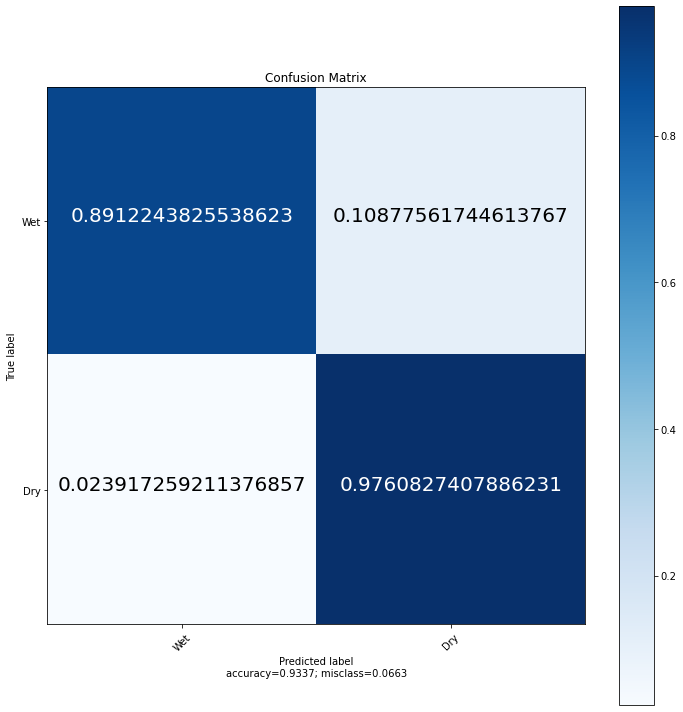

<Figure size 432x288 with 0 Axes>

<IPython.core.display.Javascript object>

In [10]:
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,normalize=True):


    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center", fontsize = 20,
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center", fontsize = 20,
                     color="white" if cm[i, j] > thresh else "black")

    #plt.rcParams['figure.figsize'] = 12, 12
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    plt.savefig('conf_matrix.png')


plot_confusion_matrix(cm = matrix,normalize=False,target_names = ['Wet', 'Dry'],title="Confusion Matrix")
plt.savefig('images/conf_matrix.png')


In [11]:
import datetime

i = 0
indexes = []
for x in trainY:
    # print(x)
    # print(g[i])
    if (g[i] == 1) & (x == 0):
        indexes.append(i)
    i = i + 1
indexes
dates = []
for x in indexes:
    dates.append(datetime.datetime.strptime(ind[x], "%Y-%m-%d %H:%M:%S"))

dates = list(dict.fromkeys(dates))
days, months, years = [], [], []
for x in dates:
    days.append(x.day)
    months.append(x.month)
    years.append(x.year)
days = np.asarray(days)
months = np.asarray(months)
years = np.asarray(years)

unique, counts = np.unique(days, return_counts=True)
print(dict(zip(unique, counts)))
unique, counts = np.unique(months, return_counts=True)
print(dict(zip(unique, counts)))
unique, counts = np.unique(years, return_counts=True)
print(dict(zip(unique, counts)))

{1: 2, 2: 1, 3: 2, 4: 2, 5: 1, 6: 1, 7: 3, 8: 4, 9: 8, 10: 3, 11: 4, 12: 1, 13: 3, 14: 2, 15: 2, 16: 2, 17: 5, 18: 7, 19: 3, 20: 4, 21: 7, 22: 3, 23: 6, 24: 4, 25: 5, 26: 6, 27: 3, 28: 2, 29: 5, 30: 3, 31: 4}
{1: 7, 2: 11, 3: 3, 4: 12, 5: 11, 6: 10, 7: 24, 8: 4, 9: 9, 10: 11, 11: 5, 12: 1}
{2018: 72, 2019: 36}


<IPython.core.display.Javascript object>

In [12]:
print(h.history.keys())

dict_keys(['loss', 'accuracy'])


<IPython.core.display.Javascript object>

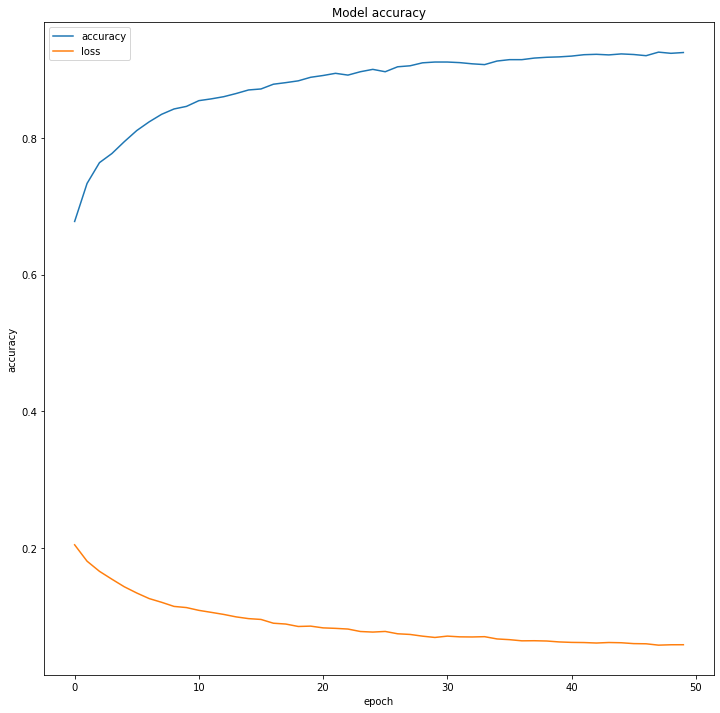

<IPython.core.display.Javascript object>

In [13]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = 12, 12
#plt.rcParams['figure.figsize'] = [15, 10]
# summarize history for accuracy
plt.plot(h.history['accuracy'])
plt.plot(h.history['loss'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.savefig('images/acc.png')
plt.show()


In [14]:
nine_five = difference.quantile(0.95)
nine_five


haarsteeg            1815.218413
bokhoven               42.322290
helft_heuvelweg       788.487266
maaspoort_rompert    1446.551519
oud_engelseweg       1670.050371
Name: 0.95, dtype: float64

<IPython.core.display.Javascript object>

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculation of Mean Squared Error (MSE)
mse, mae = [], []
mse.append(mean_squared_error(rain["act_haarsteeg"], rain["grid_haarsteeg"]))
mse.append(mean_squared_error(rain["act_bokhoven"], rain["grid_bokhoven"]))
mse.append(
    mean_squared_error(rain["act_helft_heuvelweg"], rain["grid_helft_heuvelweg"])
)
mse.append(
    mean_squared_error(rain["act_maaspoort_rompert"], rain["grid_maaspoort_rompert"])
)
mse.append(mean_squared_error(rain["act_oud_engelseweg"], rain["grid_oud_engelseweg"]))

mae.append(mean_absolute_error(rain["act_haarsteeg"], rain["grid_haarsteeg"]))
mae.append(mean_absolute_error(rain["act_bokhoven"], rain["grid_bokhoven"]))
mae.append(
    mean_absolute_error(rain["act_helft_heuvelweg"], rain["grid_helft_heuvelweg"])
)
mae.append(
    mean_absolute_error(rain["act_maaspoort_rompert"], rain["grid_maaspoort_rompert"])
)
mae.append(mean_absolute_error(rain["act_oud_engelseweg"], rain["grid_oud_engelseweg"]))

dry_mse, dry_mae, wet_mse, wet_mae = [], [], [], []
haar = rain[["act_haarsteeg", "grid_haarsteeg", "dry_act_haarsteeg"]]
bok = rain[["act_bokhoven", "grid_bokhoven", "dry_act_bokhoven"]]
helf = rain[["act_helft_heuvelweg", "grid_helft_heuvelweg", "dry_act_helft_heuvelweg"]]
maar = rain[
    ["act_maaspoort_rompert", "grid_maaspoort_rompert", "dry_act_maaspoort_rompert"]
]
oud = rain[["act_oud_engelseweg", "grid_oud_engelseweg", "dry_act_oud_engelseweg"]]

dry_haar = haar[haar["dry_act_haarsteeg"] == 1]
wet_haar = haar[haar["dry_act_haarsteeg"] == 0]
dry_bok = bok[bok["dry_act_bokhoven"] == 1]
wet_bok = bok[bok["dry_act_bokhoven"] == 0]
dry_helf = helf[helf["dry_act_helft_heuvelweg"] == 1]
wet_helf = helf[helf["dry_act_helft_heuvelweg"] == 0]
dry_maar = maar[maar["dry_act_maaspoort_rompert"] == 1]
wet_maar = maar[maar["dry_act_maaspoort_rompert"] == 0]
dry_oud = oud[oud["dry_act_oud_engelseweg"] == 1]
wet_oud = oud[oud["dry_act_oud_engelseweg"] == 0]

dry_mse.append(
    mean_squared_error(dry_haar["act_haarsteeg"], dry_haar["grid_haarsteeg"])
)
wet_mse.append(
    mean_squared_error(wet_haar["act_haarsteeg"], wet_haar["grid_haarsteeg"])
)
dry_mae.append(
    mean_absolute_error(dry_haar["act_haarsteeg"], dry_haar["grid_haarsteeg"])
)
wet_mae.append(
    mean_absolute_error(wet_haar["act_haarsteeg"], wet_haar["grid_haarsteeg"])
)

dry_mse.append(mean_squared_error(dry_bok["act_bokhoven"], dry_bok["grid_bokhoven"]))
wet_mse.append(mean_squared_error(wet_bok["act_bokhoven"], wet_bok["grid_bokhoven"]))
dry_mae.append(mean_absolute_error(dry_bok["act_bokhoven"], dry_bok["grid_bokhoven"]))
wet_mae.append(mean_absolute_error(wet_bok["act_bokhoven"], wet_bok["grid_bokhoven"]))

dry_mse.append(
    mean_squared_error(
        dry_helf["act_helft_heuvelweg"], dry_helf["grid_helft_heuvelweg"]
    )
)
wet_mse.append(
    mean_squared_error(
        wet_helf["act_helft_heuvelweg"], wet_helf["grid_helft_heuvelweg"]
    )
)
dry_mae.append(
    mean_absolute_error(
        dry_helf["act_helft_heuvelweg"], dry_helf["grid_helft_heuvelweg"]
    )
)
wet_mae.append(
    mean_absolute_error(
        wet_helf["act_helft_heuvelweg"], wet_helf["grid_helft_heuvelweg"]
    )
)

dry_mse.append(
    mean_squared_error(
        dry_maar["act_maaspoort_rompert"], dry_maar["grid_maaspoort_rompert"]
    )
)
wet_mse.append(
    mean_squared_error(
        wet_maar["act_maaspoort_rompert"], wet_maar["grid_maaspoort_rompert"]
    )
)
dry_mae.append(
    mean_absolute_error(
        dry_maar["act_maaspoort_rompert"], dry_maar["grid_maaspoort_rompert"]
    )
)
wet_mae.append(
    mean_absolute_error(
        wet_maar["act_maaspoort_rompert"], wet_maar["grid_maaspoort_rompert"]
    )
)

dry_mse.append(
    mean_squared_error(dry_oud["act_oud_engelseweg"], dry_oud["grid_oud_engelseweg"])
)
wet_mse.append(
    mean_squared_error(wet_oud["act_oud_engelseweg"], wet_oud["grid_oud_engelseweg"])
)
dry_mae.append(
    mean_absolute_error(dry_oud["act_oud_engelseweg"], dry_oud["grid_oud_engelseweg"])
)
wet_mae.append(
    mean_absolute_error(wet_oud["act_oud_engelseweg"], wet_oud["grid_oud_engelseweg"])
)

error = pd.DataFrame(
    data={
        "mse": mse,
        "dry_mse": dry_mse,
        "wet_mse": wet_mse,
        "mae": mae,
        "dry_mae": dry_mae,
        "wet_mae": wet_mae,
    },
    index=[
        "haarsteeg",
        "bokhoven",
        "helft_heuvelweg",
        "maaspoort_romper",
        "oud_engelseweg",
    ],
)
error

,mse,dry_mse,wet_mse,mae,dry_mae,wet_mae
haarsteeg,4.497525e+07,3.422150e+06,7.993587e+07,1422.267703,200.730050,2450.006057
bokhoven,2.876874e+04,2.660869e+03,5.778369e+04,34.420821,5.317910,66.764304
helft_heuvelweg,5.150450e+06,2.621783e+05,8.597023e+06,497.792743,45.749283,816.514886
maaspoort_romper,1.898142e+07,1.552265e+06,3.302903e+07,928.729835,105.736879,1592.048824
oud_engelseweg,2.188356e+07,1.104711e+06,3.826683e+07,1020.525133,101.890478,1744.830942


<IPython.core.display.Javascript object>

In [16]:
worst = difference.copy()
worst_haarsteeg = worst[worst["haarsteeg"] >= nine_five["haarsteeg"]]
worst_bokhoven = worst[worst["bokhoven"] >= nine_five["bokhoven"]]
worst_helft_heuvelweg = worst[worst["helft_heuvelweg"] >= nine_five["helft_heuvelweg"]]
worst_maaspoort_rompert = worst[
    worst["maaspoort_rompert"] >= nine_five["maaspoort_rompert"]
]
worst_oud_engelseweg = worst[worst["oud_engelseweg"] >= nine_five["oud_engelseweg"]]
worst_maaspoort_rompert

,Begin,haarsteeg,bokhoven,helft_heuvelweg,maaspoort_rompert,oud_engelseweg
16,2018-01-02 16:00:00,5428.057398,156.736989,2100.930087,4175.593452,4493.603742
17,2018-01-02 17:00:00,4073.290997,111.512757,1701.758626,2649.011022,3554.286121
20,2018-01-02 20:00:00,5009.038420,108.168406,1494.331855,2856.468956,2859.993946
21,2018-01-02 21:00:00,13246.159982,346.669743,3634.948842,8238.793174,8866.739844
22,2018-01-02 22:00:00,38156.497257,903.790030,11040.584553,23391.423972,22228.607490
...,...,...,...,...,...,...
13544,2019-07-20 09:00:00,9105.015423,337.550088,3705.618461,11645.980651,24263.400461
13548,2019-07-20 13:00:00,1696.081494,15.592968,857.612095,1454.697803,1347.272246
13630,2019-07-23 23:00:00,1207.355918,46.620735,29131.956499,10170.881079,25864.799022
13631,2019-07-24 00:00:00,207.068758,0.000000,4992.708028,2062.417315,6555.021804


<IPython.core.display.Javascript object>

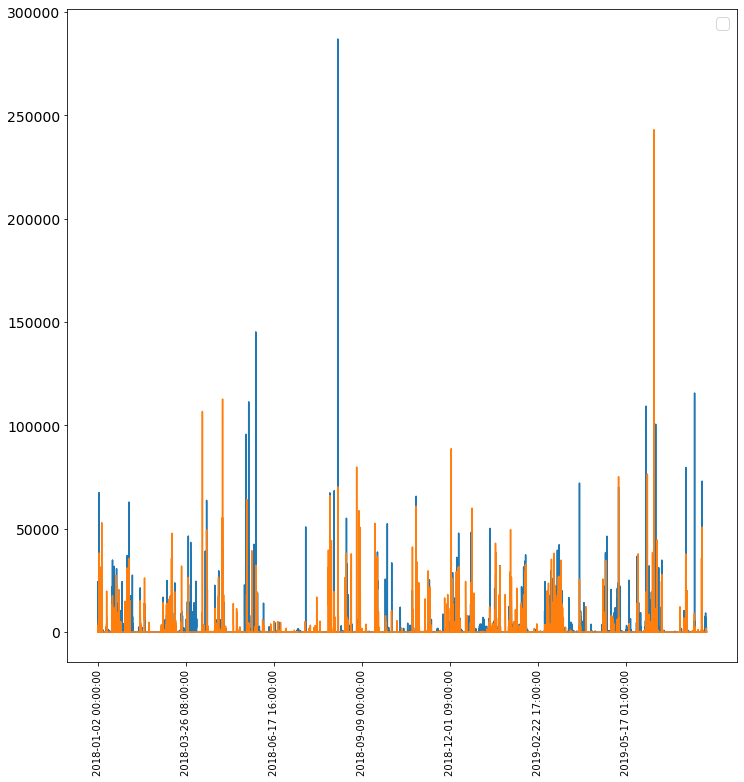

<IPython.core.display.Javascript object>

In [17]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 12
y = rain[["grid_haarsteeg", "act_haarsteeg"]]
x = rain["Begin"]

plt.legend(("Predicted", "Actual"), fontsize=16)
plt.xlabel(None)
plt.tick_params(labelsize=14)
plt.tick_params(axis='x',labelsize=10,labelrotation=90)
locs, labels = plt.xticks()
plt.xticks(np.arange(0, len(rain), step=2000))
plt.plot(x, y);


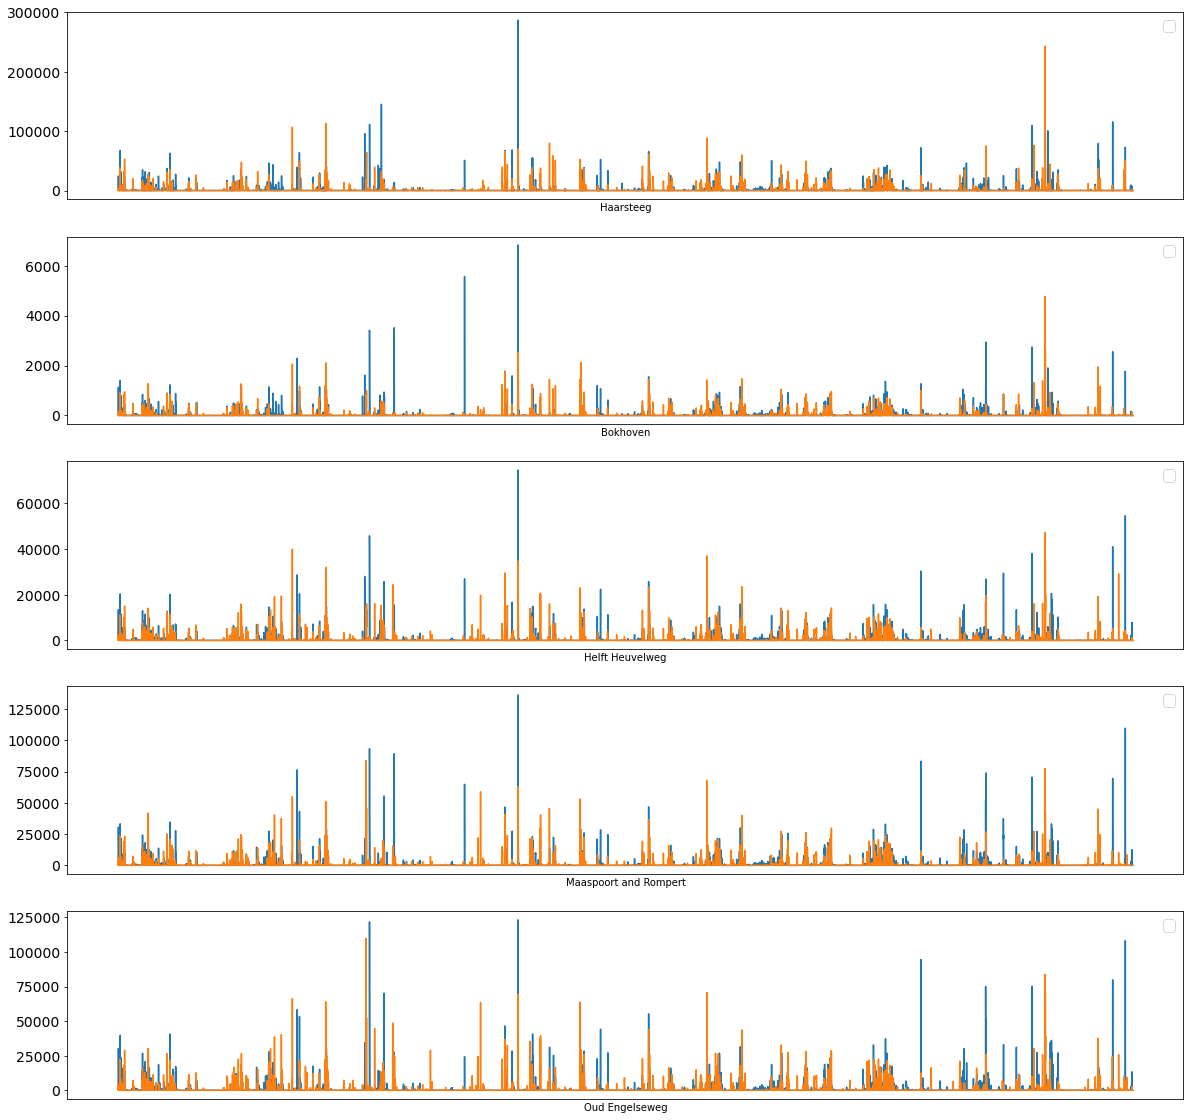

<IPython.core.display.Javascript object>

In [18]:
fig, axs = plt.subplots(5,1, figsize=(20, 20))
#fig.subplots_adjust(hspace = .5, wspace=.001)
label = ["Haarsteeg","Bokhoven","Helft Heuvelweg","Maaspoort and Rompert", "Oud Engelseweg"]
axs = axs.ravel()
arr = [["grid_haarsteeg", "act_haarsteeg"],["grid_bokhoven", "act_bokhoven"],["grid_helft_heuvelweg", "act_helft_heuvelweg"],["grid_maaspoort_rompert", "act_maaspoort_rompert"],["grid_oud_engelseweg", "act_oud_engelseweg"]]
for i in range(5):
    g = arr[i]
    y = rain[[g[0], g[1]]]
    x = rain["Begin"]
    #axs[i].contourf(np.random.rand(10,10),5,cmap=plt.cm.Oranges)
    #axs[i].set_title(str(250+i))
    axs[i].legend(("Predicted", "Actual"), fontsize=16)
    axs[i].set_xlabel(label[i])
    axs[i].tick_params(labelsize=14)
    axs[i].tick_params(axis='x',labelsize=0,labelrotation=90, length=0)
    #locs, labels = axs[i].xticks()
    axs[i].set_xticks([])
    axs[i].plot(x, y);
plt.savefig('images/rain_plot.png')


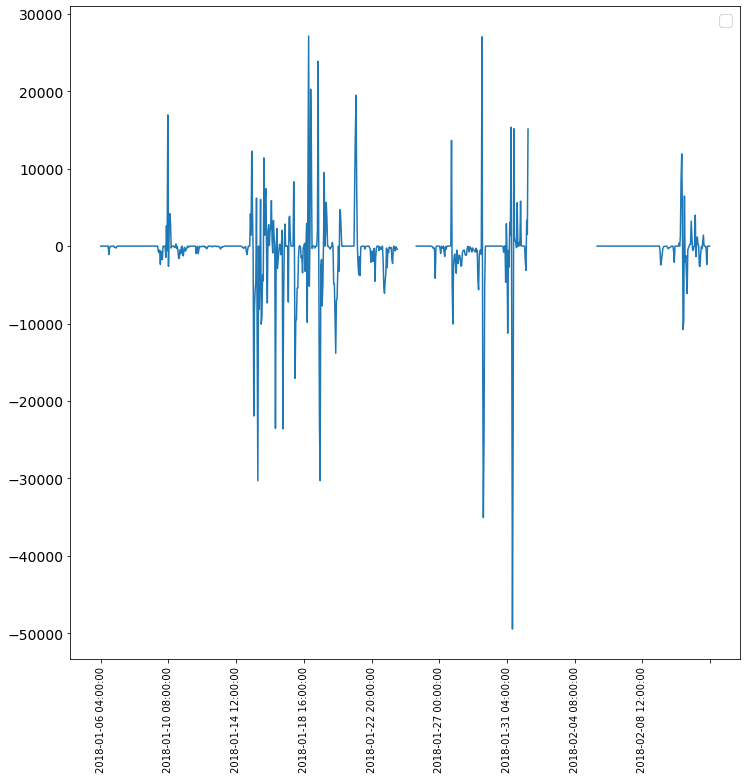

<IPython.core.display.Javascript object>

In [129]:
%matplotlib inline
plt.rcParams["figure.figsize"] = 12, 12
y = difference[["haarsteeg"]][100:1000]
x = difference["Begin"][100:1000]

plt.legend(("Predicted", "Actual"), fontsize=16)
plt.xlabel(None)
plt.tick_params(labelsize=14)
plt.tick_params(axis="x", labelsize=10, labelrotation=90)
locs, labels = plt.xticks()
plt.xticks(np.arange(0, 1000, step=100))
plt.plot(x, y)

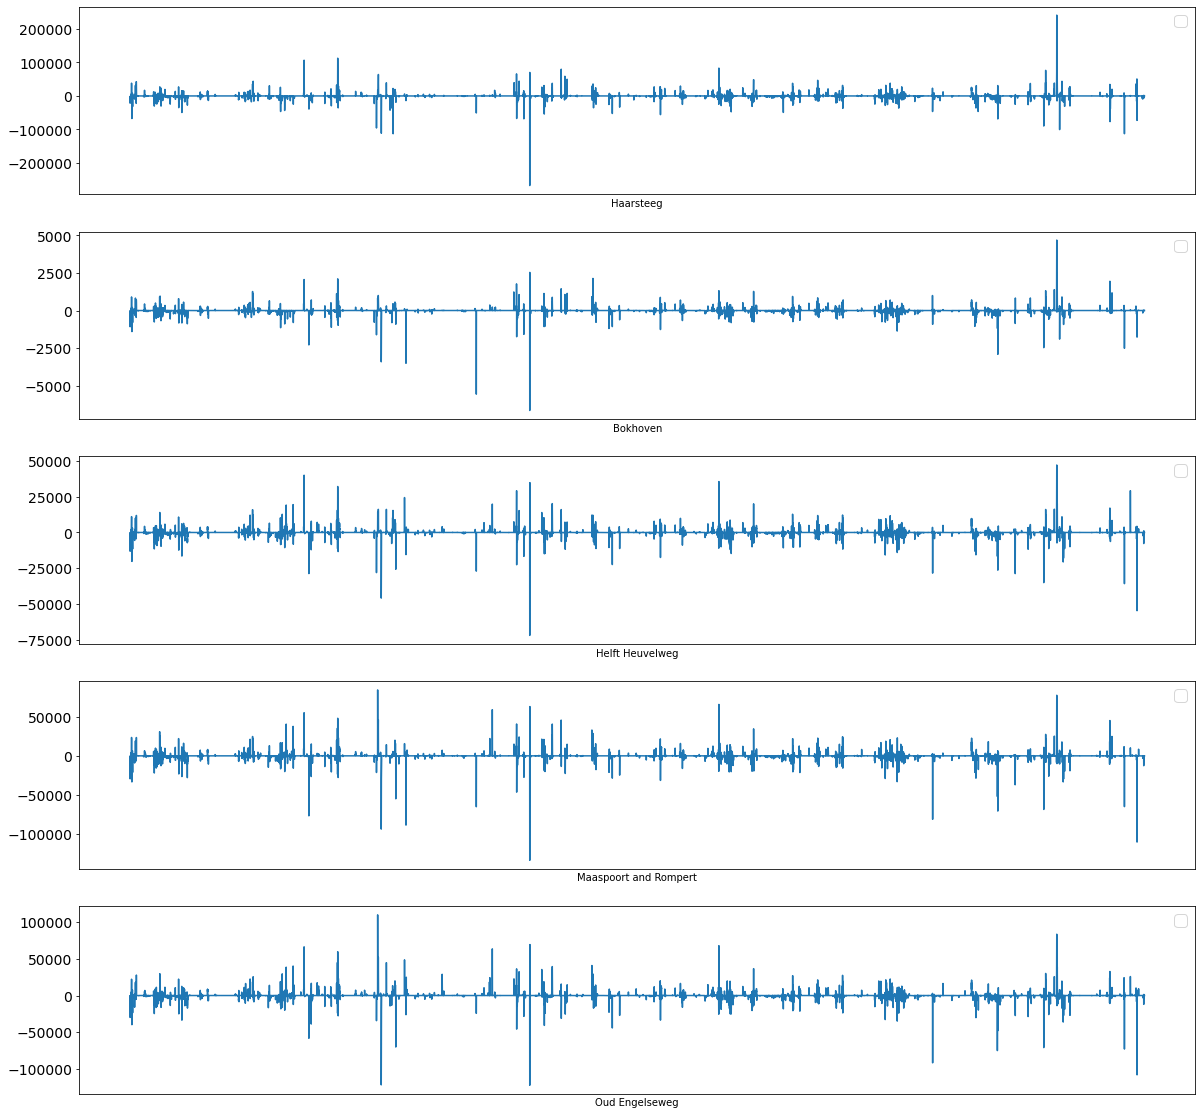

<IPython.core.display.Javascript object>

In [225]:
fig, axs = plt.subplots(5, 1, figsize=(20, 20))
# fig.subplots_adjust(hspace = .5, wspace=.001)
label = [
    "Haarsteeg",
    "Bokhoven",
    "Helft Heuvelweg",
    "Maaspoort and Rompert",
    "Oud Engelseweg",
]
axs = axs.ravel()
arr = [
    "haarsteeg",
    "bokhoven",
    "helft_heuvelweg",
    "maaspoort_rompert",
    "oud_engelseweg",
]
for i in range(5):
    g = arr[i]
    y = difference[g]
    x = difference["Begin"]
    # axs[i].contourf(np.random.rand(10,10),5,cmap=plt.cm.Oranges)
    # axs[i].set_title(str(250+i))
    axs[i].legend(("Predicted", "Actual"), fontsize=16)
    axs[i].set_xlabel(label[i])
    axs[i].tick_params(labelsize=14)
    axs[i].tick_params(axis="x", labelsize=0, labelrotation=90, length=0)
    # locs, labels = axs[i].xticks()
    axs[i].set_xticks([])
    axs[i].plot(x, y)
plt.savefig("images/diff_plot.png")

In [6]:
top_difference = difference.sort_values(by=["haarsteeg"], ascending=False)
c = 0
top_rain = []
top_diff = []
arr1 = [
    ["haarsteeg", "Begin", "grid_haarsteeg", "act_haarsteeg"],
    ["bokhoven", "Begin", "grid_bokhoven", "act_bokhoven"],
    ["helft_heuvelweg", "Begin", "grid_helft_heuvelweg", "act_helft_heuvelweg"],
    ["maaspoort_rompert", "Begin", "grid_maaspoort_rompert", "act_maaspoort_rompert"],
    ["oud_engelseweg", "Begin", "grid_oud_engelseweg", "act_oud_engelseweg"],
]
for x in arr1:
    dfs_rain = []
    dfs_diff = []
    for index, row in top_difference[0:10].iterrows():
        if c != 10:
            # print(rain[["Begin", "grid_bokhoven", "act_bokhoven"]][index - 500 : index + 500])
            dfs_rain.append(rain[x[1:4]][index - 400 : index + 400])
            # print(difference[["bokhoven"]][index - 500 : index + 500])
            dfs_diff.append(difference[x[0:2]][index - 24 : index + 24])
    top_rain.append(dfs_rain)
    top_diff.append(dfs_diff)
top_difference

,Begin,haarsteeg,bokhoven,helft_heuvelweg,maaspoort_rompert,oud_engelseweg
12627,2019-06-12 04:00:00,241297.854844,4691.394136,47042.961003,77140.112347,83570.425364
2831,2018-04-29 23:00:00,112714.120591,2107.940189,32054.390631,47852.756649,59704.675515
2373,2018-04-10 21:00:00,106707.468199,2063.888330,39930.342367,54889.549435,66339.010787
12632,2019-06-12 09:00:00,88208.057946,2489.267811,33243.099711,40479.601842,67878.720456
8024,2018-12-02 09:00:00,83129.117325,1317.946438,35495.541966,65471.397641,67891.012397
...,...,...,...,...,...,...
12666,2019-06-13 19:00:00,-100557.985577,-1904.162563,-6034.020602,-10369.688617,-4864.997534
3425,2018-05-24 17:00:00,-111353.453298,-2834.888994,-35556.158606,-41446.100803,-55475.329374
13549,2019-07-20 14:00:00,-112851.692903,-2516.059546,-35704.852586,-64672.385888,-72946.461836
3586,2018-05-31 10:00:00,-112902.521544,294.324943,-449.929870,4002.271035,3361.644915


<IPython.core.display.Javascript object>

In [10]:
b = 0
import matplotlib.pyplot as plt
for k in top_rain:

    a = 0
    for i in range(10):
        if i == 5:
            a = 0
            b = b + 1
        y = k[i]
        y = y.drop(["Begin"], axis=1)
        x = k[i]["Begin"]
        plt.rcParams["figure.figsize"] = 12, 12
        plt.legend(("Predicted", "Actual"), fontsize=22)
        plt.xlabel(None)
        plt.tick_params(labelsize=22)
        plt.tick_params(axis="x", labelsize=22, labelrotation=90)
        locs, labels = plt.xticks()
        plt.xticks(np.arange(0, 1000, step=100))
        plt.plot(x, y)
        filename = "third{:d}_{:d}.png".format(a, b)
        plt.savefig("images/rain/" + filename, bbox_inches="tight")
        plt.clf()
        a = a + 1
    b = b + 1
b = 0

for k in top_diff:

    a = 0
    for i in range(10):
        if i == 5:
            a = 0
            b = b + 1
        y = k[i]
        x = y["Begin"]
        y = y.drop(["Begin"], axis=1)
        plt.rcParams["figure.figsize"] = 12, 12
        plt.legend(("Predicted", "Actual"), fontsize=22)
        plt.xlabel(None)
        plt.tick_params(labelsize=22)
        plt.tick_params(axis="x", labelsize=22, labelrotation=90)
        locs, labels = plt.xticks()
        plt.xticks(np.arange(0, 1000, step=100))
        plt.plot(x, y)
        filename = "third{:d}_{:d}.png".format(a, b)
        plt.savefig("images/error/" + filename, bbox_inches="tight")
        plt.clf()
        a = a + 1
    b = b + 1

<Figure size 864x864 with 0 Axes>

<IPython.core.display.Javascript object>

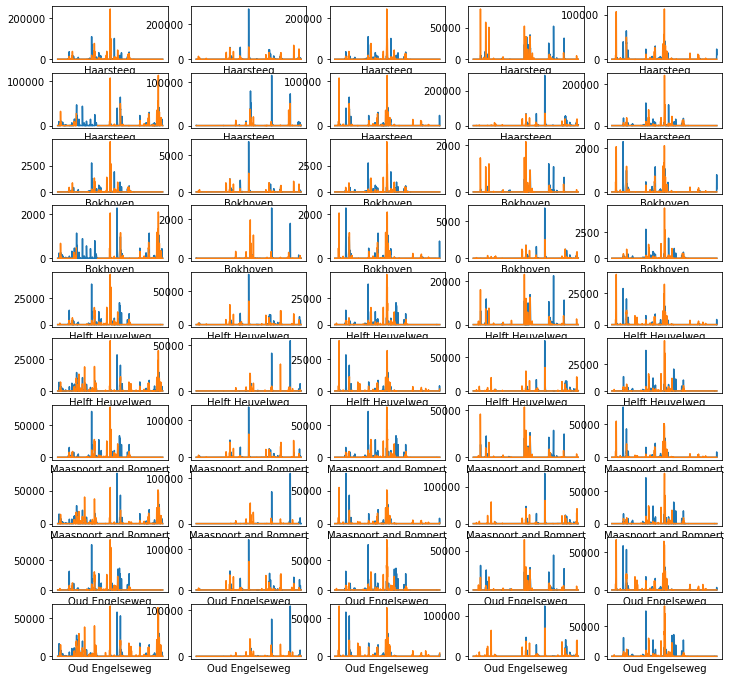

<IPython.core.display.Javascript object>

In [235]:
# fig, axs = plt.subplots(5, 5, figsize=(20, 20))
fig, axs = plt.subplots(10, 5)
# fig.subplots_adjust(hspace = .5, wspace=.001)
label = [
    "Haarsteeg","Haarsteeg",
    "Bokhoven","Bokhoven",
    "Helft Heuvelweg","Helft Heuvelweg",
    "Maaspoort and Rompert","Maaspoort and Rompert",
    "Oud Engelseweg","Oud Engelseweg"
]
# axs = axs.ravel()
b = 0
for k in top_rain:
    
    a = 0
    for i in range(10):
        if i==5:
            a=0
            b=b+1
        y = k[i]
        y = y.drop(["Begin"], axis=1)
        x = k[i]["Begin"]
        # axs[i].contourf(np.random.rand(10,10),5,cmap=plt.cm.Oranges)
        # axs[i].set_title(str(250+i))
        # axs[a, b].legend(("Predicted", "Actual"), fontsize=16)
        axs[b,a].set_xlabel(label[b])
        # axs[a, b].tick_params(labelsize=14)

        axs[b,a].tick_params(axis="x", labelsize=0, labelrotation=90, length=0)
        # locs, labels = axs[i].xticks()
        axs[b,a].set_xticks([])
        axs[b,a].plot(x, y)
        a=a+1
    b = b + 1
